In [14]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
fleetsize_06 = []
fleetsize_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date

        



        with open(f'../output/demand_variation/results/{month}_{day}_{6}_fleetsize.txt'.format(month, day), 'r') as f:
            fleetsize_06.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))

        with open(f'../output/demand_variation/results/{month}_{day}_{7}_fleetsize.txt'.format(month, day), 'r') as f:
            fleetsize_07.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
fleetsize_06 = np.array(fleetsize_06)
fleetsize_07 = np.array(fleetsize_07)


In [43]:
with open(f'../output/demand_variation/schedule/{month}_{day}_{6}') as f:
    schedule_06 = f.readlines()

FileNotFoundError: [Errno 2] No such file or directory: '../output/demand_variation/schedule/12_31_6'

In [17]:
result = pd.DataFrame({'val':np.concatenate([fleetsize_06, fleetsize_07]), 'alpha':np.concatenate([np.repeat(0.6, len(fleetsize_06)), np.repeat(0.7, len(fleetsize_07))])})

In [21]:
result

,val,alpha
0,18,0.6
1,18,0.6
2,15,0.6
3,16,0.6
4,23,0.6
...,...,...
725,18,0.7
726,15,0.7
727,18,0.7
728,16,0.7


Text(0.5, 1.0, 'Distribution of Fleet Size for 365 Autorregressive Samples')

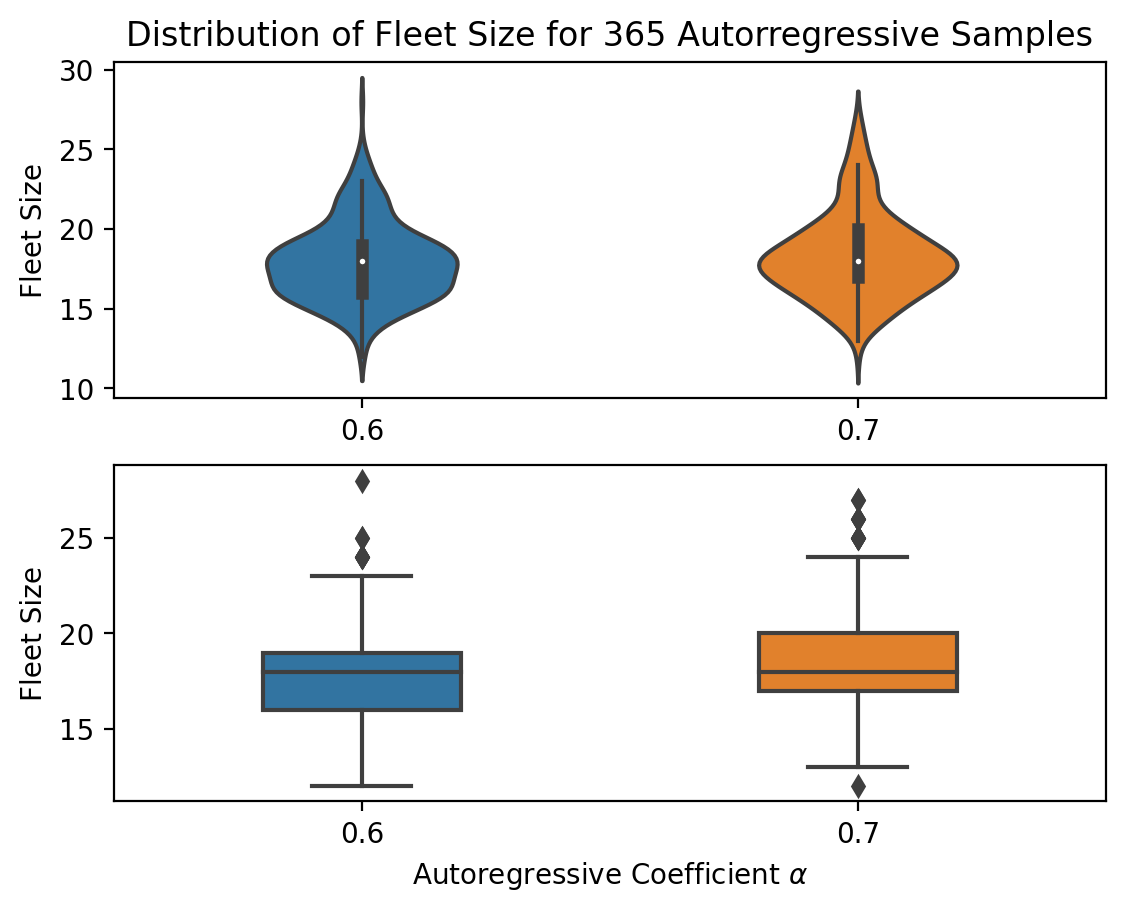

In [38]:
fig, ax = plt.subplots(nrows=2, dpi=200)
sns.violinplot(data=result, x='alpha', y='val',width=0.4, ax=ax[0])
sns.boxplot(data=result, x='alpha', y='val',width=0.4, ax=ax[1])
ax[0].set(xlabel='')
ax[1].set(xlabel='Autoregressive Coefficient $\\alpha$')
for i in range(2):
    ax[i].set(ylabel='Fleet Size')
ax[0].set_title('Distribution of Fleet Size for 365 Autorregressive Samples')


In [6]:
import os

directory_path = "../output/demand_variation/schedule"  # Replace with the path to your directory

# List all files in the directory
file_list = os.listdir(directory_path)

# Iterate through the files and delete those ending with "7"
for filename in file_list:
    if filename.endswith("7.csv"):
        file_path = os.path.join(directory_path, filename)
        os.remove(file_path)
        print(f"Deleted: {filename}")


Deleted: 1_8_7.csv
Deleted: 3_31_7.csv
Deleted: 1_10_7.csv
Deleted: 7_1_7.csv
Deleted: 1_6_7.csv
Deleted: 1_4_7.csv
Deleted: 1_11_7.csv
Deleted: 1_13_7.csv
Deleted: 1_12_7.csv
Deleted: 10_2_7.csv
Deleted: 1_1_7.csv
Deleted: 1_7_7.csv
Deleted: 1_9_7.csv
Deleted: 10_1_7.csv
Deleted: 1_3_7.csv
Deleted: 1_5_7.csv
Deleted: 1_2_7.csv
